# Jellyfish species recognition using CNN

## Data

Importing all the data. Ignoring the suggested train/test/validation split to avoid overfitting on a particular dataset.

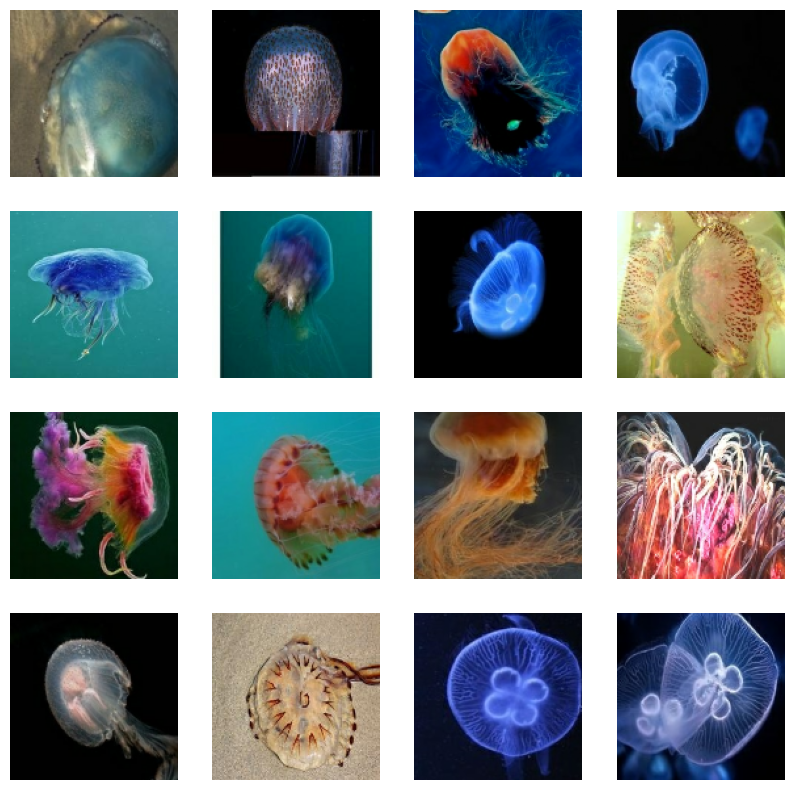

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os
import re

tf.random.set_seed(504)

image_paths = []
for dirname, _, filenames in os.walk('/kaggle/input/jellyfish-types'):
    for filename in filenames:
        image_paths.append(os.path.join(dirname, filename))

match_type = re.compile('.*/([^/]*)_jellyfish.*')
types = [match_type.match(path).group(1) for path in image_paths]
one_hot = pd.get_dummies(types, dtype=int)
labels = one_hot.columns
y = one_hot.to_numpy()

def load_image(path):
    content = tf.io.read_file(path)
    image = tf.io.decode_jpeg(content)
    scaled = tf.image.resize(image, size = (128, 128)) # To make sure all images have same size
    return tf.cast(scaled, tf.float32) / 255

X = np.array([load_image(path) for path in image_paths])

random_jellyfish = [X[np.random.randint(0, len(X)), :, :, :] for i in range(16)]

fig, axes = plt.subplots(4, 4, figsize=(10,10))

for index, kernel in enumerate(random_jellyfish):
    ax=axes[index // 4][index % 4]
    ax.axis('off')
    ax.imshow(kernel)

0.012932016

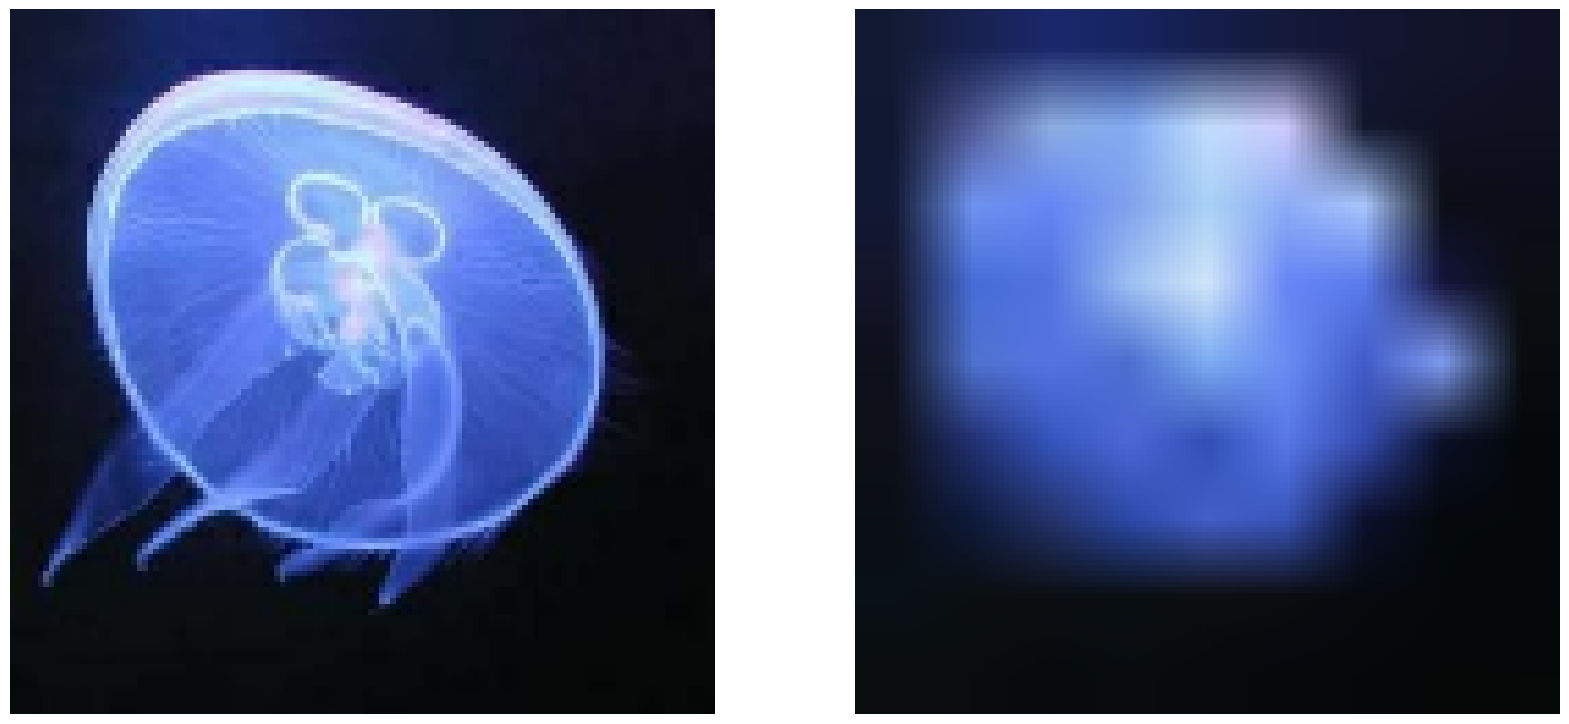

In [6]:
small = tf.image.resize(X[2], size=(9, 9))
uncompressed = tf.image.resize(small, size=(128, 128))

figure = plt.figure(figsize=(20, 10))
ax = figure.add_subplot(1, 2, 1)
ax.axis('off')
ax.imshow(X[2])

ax = figure.add_subplot(1, 2, 2)
ax.axis('off')
ax.imshow(uncompressed)

mse = tf.keras.losses.MeanSquaredError()
mse(X[2], uncompressed).numpy()

The network tends to overfit with only 1879 samples. In order to get more samples, some variations are added to the train and validation data. This helped. The random brightness seemed to do the most difference.

Adding some variation with random noise add is worth a consideration.

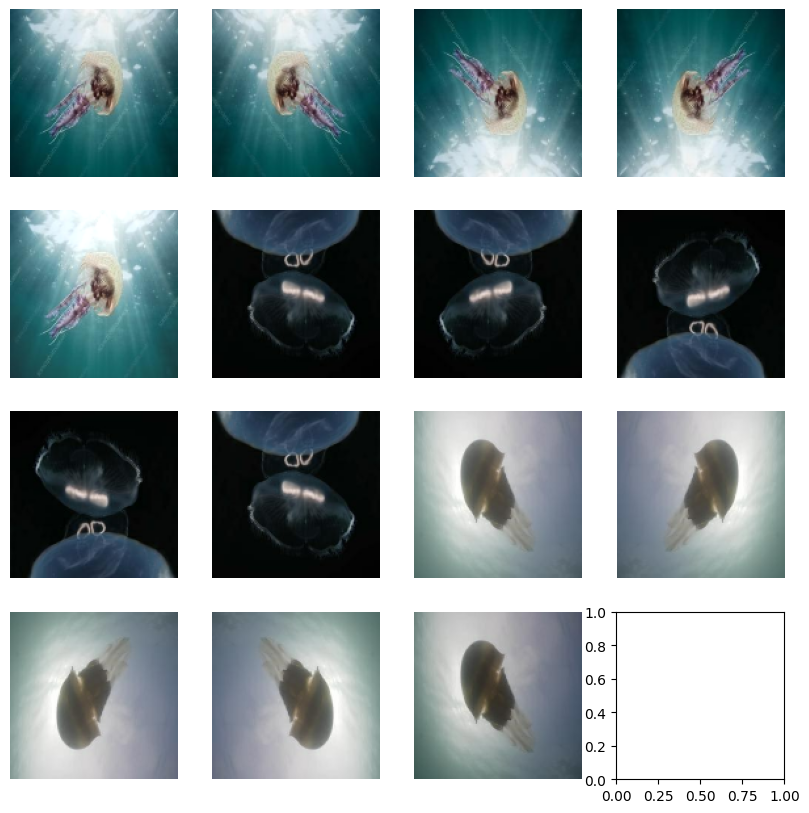

In [3]:
def add_variations(X, y):
    def variations(int_image):
        flip_lr = tf.image.flip_left_right(int_image)
        flip_ud = tf.image.flip_up_down(int_image)
        img180 = tf.image.flip_up_down(flip_lr)
        return [int_image, flip_lr, flip_ud, img180, 
                tf.image.random_brightness(int_image, .1)]
    
    x_element_shape = X.shape[1:]
    y_element_shape = y.shape[1:]
    
    X = np.array([variations(x) for x in X])
    y = np.array([np.full((X.shape[1], *v.shape), v) for v in y])
    
    return X.reshape([-1, *x_element_shape]), y.reshape(-1, *y_element_shape)

    
X_, X_test, y_, y_test = train_test_split(X, y, random_state=504)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, random_state=504)
X_train, y_train = add_variations(X_train, y_train)

fig, axes = plt.subplots(4, 4, figsize=(10,10))

for index, kernel in enumerate(X_train[:15]):
    ax=axes[index // 4][index % 4]
    ax.axis('off')
    ax.imshow(kernel)

## The Network
The network ended up quite deep, so I tried Swish instead of ReLU. It didn't seem to matter too much, though.

Keeping the network down to not too many parameters seemed to help overfitting.

In [4]:
cnn = tf.keras.models.Sequential([
    layers.Input(X_train.shape[1:]),
    layers.Conv2D(3, 3, activation='swish', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 5, activation='swish', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='swish', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='swish', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='swish', padding='same'),
    layers.SpatialDropout2D(.5),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(units=128, activation='swish'),
    layers.Dropout(.5),
    layers.Dense(units=64, activation='swish'),
    layers.Dropout(.3),
    layers.Dense(units=32, activation='swish'),
    layers.Dropout(.2),
    layers.Dense(units=y.shape[1], activation='softmax')
])

cnn.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005), metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 3)       84        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 3)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        1216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0

Sooner or later the network overfits, so it's good to use early stopping.

I always prefer val_loss as the monitor. If we use val_accuracy we risk overfitting the validation data. 'loss' and 'accuracy' are quite meaningless here.

In [5]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights=True)

history = cnn.fit(X_train, y_train, 
                  epochs = 100, 
                  validation_data = (X_valid, y_valid),
                  callbacks = [es])

Epoch 1/100


2023-10-29 06:07:50.484697: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


165/165 [==============================] - 16s 14ms/step - loss: 1.6939 - accuracy: 0.2723 - val_loss: 1.5960 - val_accuracy: 0.3144
Epoch 2/100
165/165 [==============================] - 2s 10ms/step - loss: 1.4786 - accuracy: 0.3975 - val_loss: 1.3614 - val_accuracy: 0.4278
Epoch 3/100
165/165 [==============================] - 2s 10ms/step - loss: 1.3481 - accuracy: 0.4519 - val_loss: 1.2466 - val_accuracy: 0.4816
Epoch 4/100
165/165 [==============================] - 2s 10ms/step - loss: 1.2671 - accuracy: 0.4833 - val_loss: 1.1858 - val_accuracy: 0.5156
Epoch 5/100
165/165 [==============================] - 2s 10ms/step - loss: 1.2138 - accuracy: 0.5080 - val_loss: 1.1172 - val_accuracy: 0.5581
Epoch 6/100
165/165 [==============================] - 2s 10ms/step - loss: 1.1429 - accuracy: 0.5386 - val_loss: 1.0479 - val_accuracy: 0.5892
Epoch 7/100
165/165 [==============================] - 2s 10ms/step - loss: 1.0997 - accuracy: 0.5595 - val_loss: 0.9818 - val_accuracy: 0.5949
Epo

## The outcome

We see the overfitting clearly below.

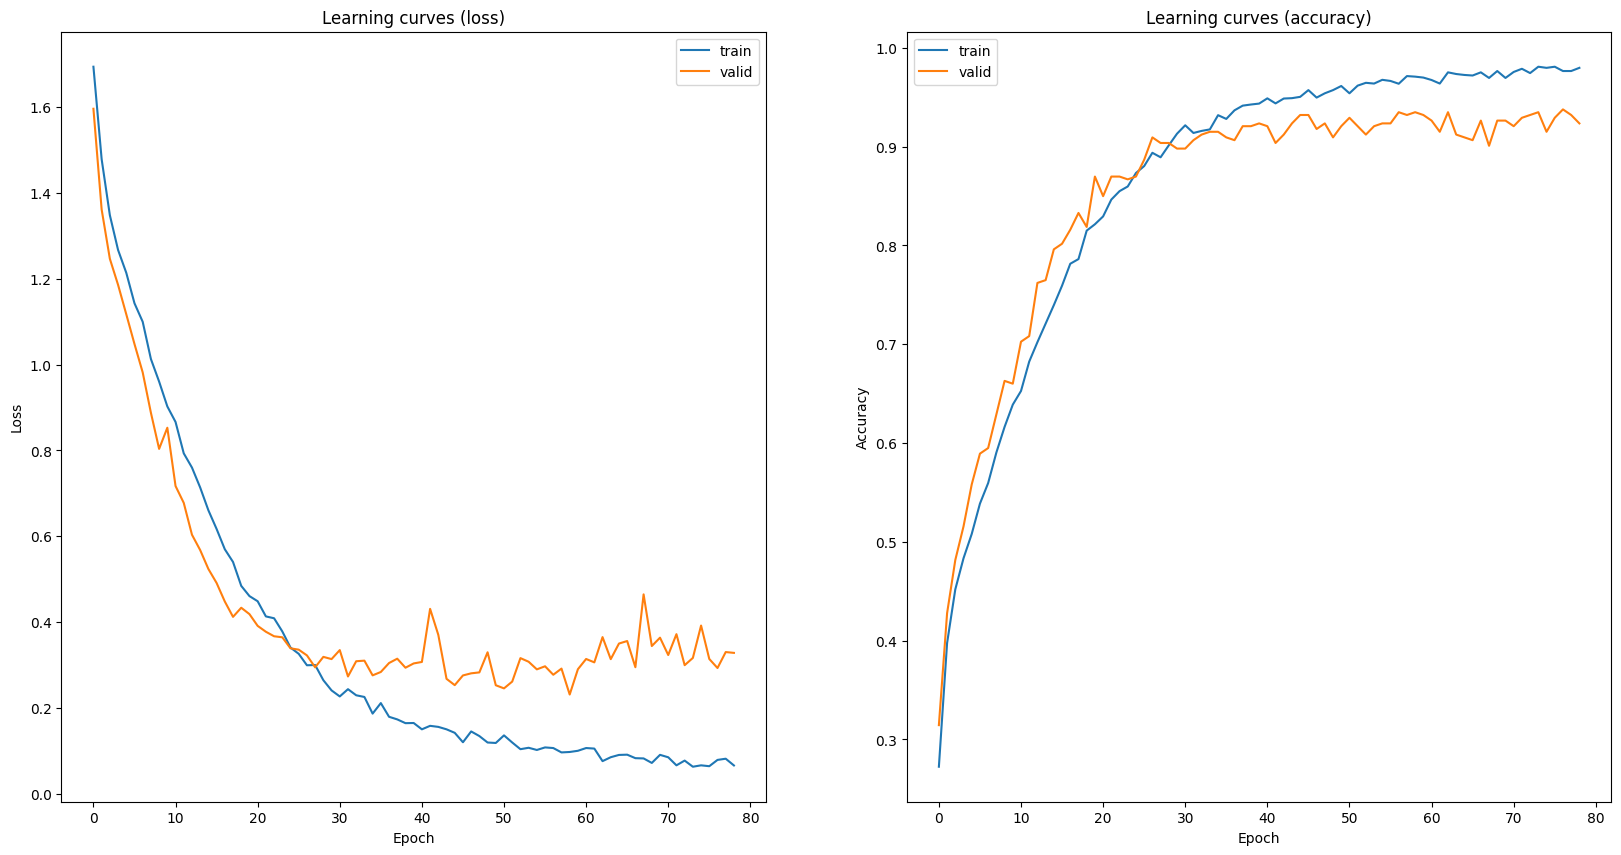

In [6]:
figure = plt.figure(figsize=(20, 10))
ax = figure.add_subplot(1, 2, 1, title='Learning curves (loss)')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(history.history['loss'], label = 'train')
ax.plot(history.history['val_loss'], label = 'valid')
ax.legend()

ax = figure.add_subplot(1, 2, 2, title='Learning curves (accuracy)')
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.plot(history.history['accuracy'], label = 'train')
ax.plot(history.history['val_accuracy'], label = 'valid')
ax.legend()

plt.show()

The final result is okay, though.

In [7]:
train_eval = cnn.evaluate(X_train, y_train)
validation_eval = cnn.evaluate(X_valid, y_valid)
test_eval = cnn.evaluate(X_test, y_test)
print("Error on test data: {p:.2f}%".format(p = 100*(1-test_eval[1])))

15/15 [==============================] - 0s 17ms/step - loss: 0.1996 - accuracy: 0.9511
Error on test data: 4.89%


## Feature maps

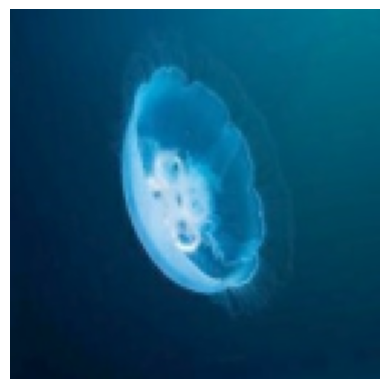

In [8]:
plt.axis('off')
plt.imshow(X_test[0])

plt.show()

### Lowest convolutional layer

This was meant as a learnable resize layer, but interestingly it's extracted some features.

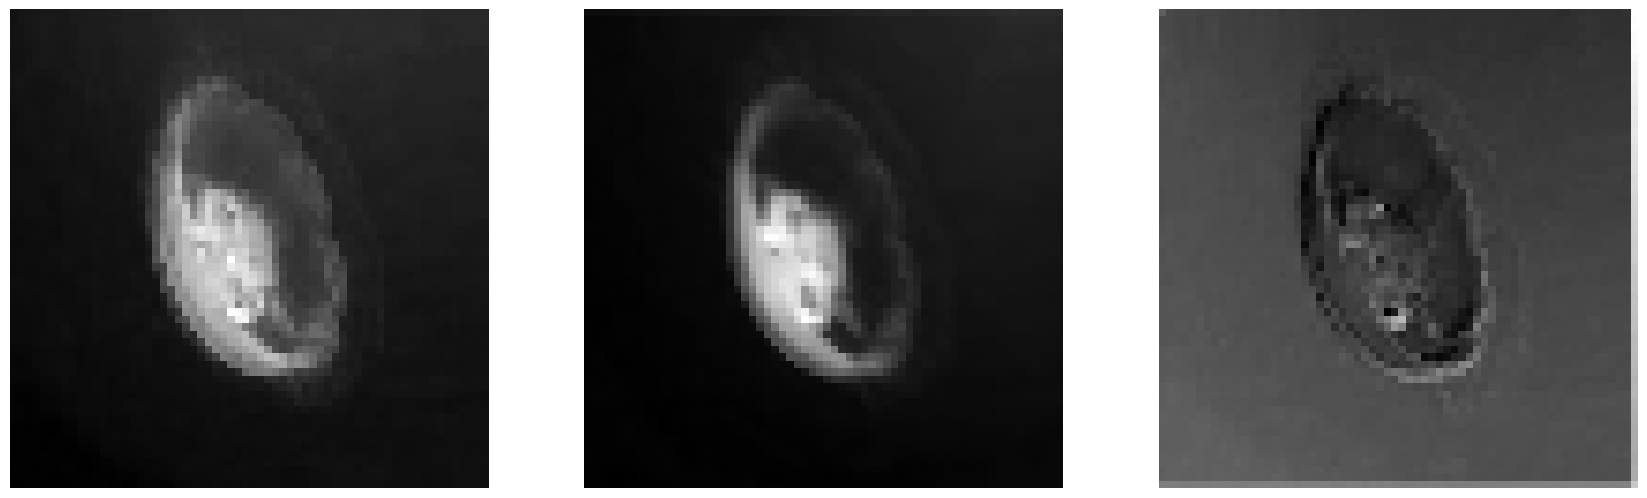

In [9]:
convolutional_layer = tf.keras.models.Sequential(cnn.layers[0: 2])
feature_maps = convolutional_layer(X_test[0:1])

fig, axes = plt.subplots(1, 3, figsize=(21,7))
for index in range(3):
    ax=axes[index]
    ax.axis('off')
    ax.imshow(feature_maps[0, :, :, index], cmap='gray')


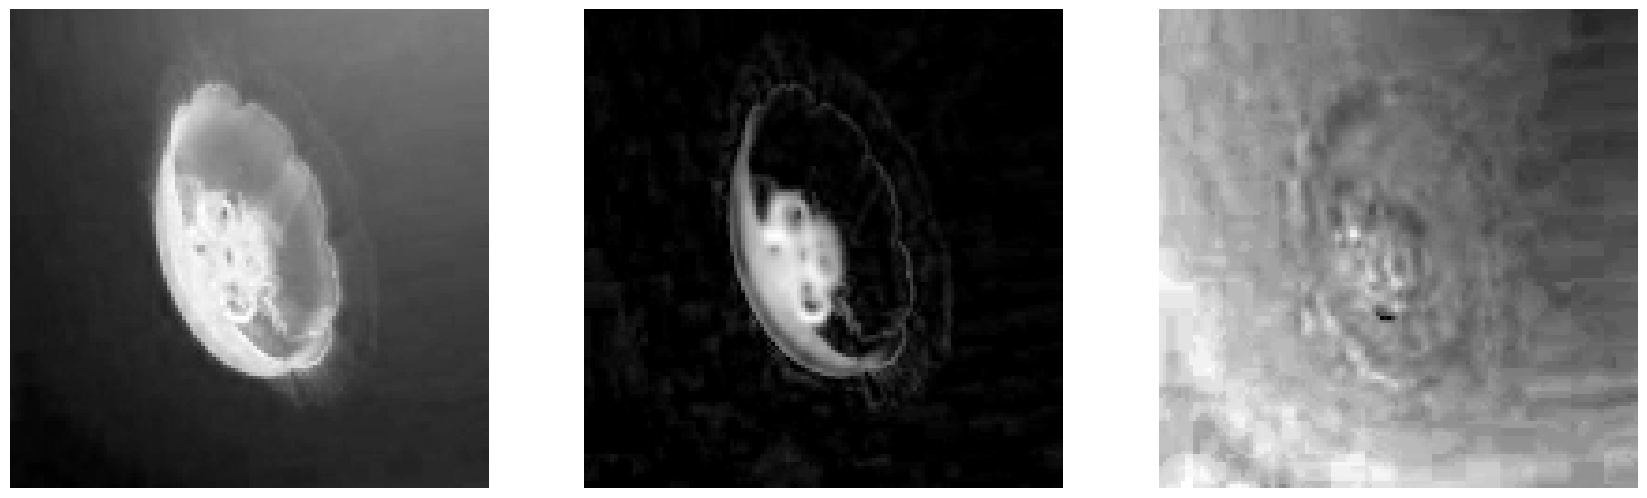

In [10]:
from matplotlib.colors import rgb_to_hsv

hsv = rgb_to_hsv(X_test[0])

fig, axes = plt.subplots(1, 3, figsize=(21,7))

axes[0].axis('off')
axes[0].imshow(hsv[:, :, 2], cmap='gray')

axes[1].axis('off')
axes[1].imshow(1-hsv[:, :, 1], cmap='gray')


axes[2].axis('off')
axes[2].imshow(hsv[:, :, 0], cmap='gray')


### Second convolutional layer

1/1 [==============================] - 0s 118ms/step


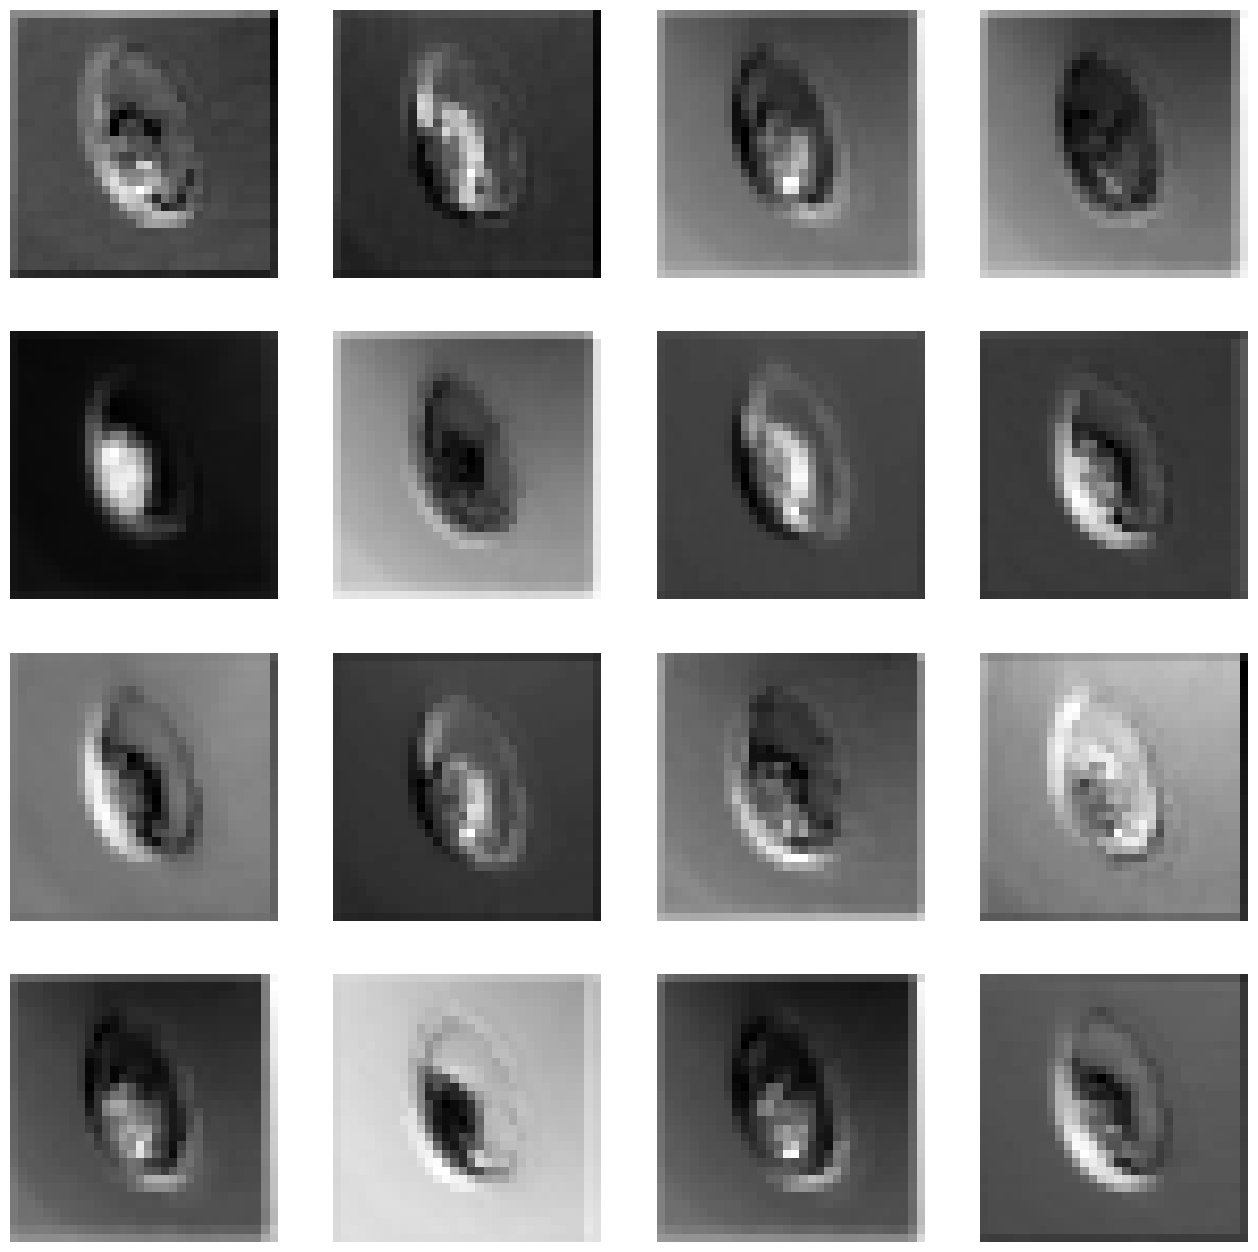

In [11]:
early_layers = cnn.layers[0:4]
part_cnn = tf.keras.models.Sequential(early_layers)
feature_maps2 = part_cnn.predict(X_test[0: 1])

size = feature_maps2.shape[3]
ncols = 4
nrows = (size - 1) // 4 + 1

fig, axes = plt.subplots(nrows, ncols, figsize=(16,16))
for index in range(size):
    ax=axes[index // ncols][index % ncols]
    ax.axis('off')
    ax.imshow(feature_maps2[0, :, :, index], cmap='gray')

### Third convolutional layer

1/1 [==============================] - 0s 106ms/step


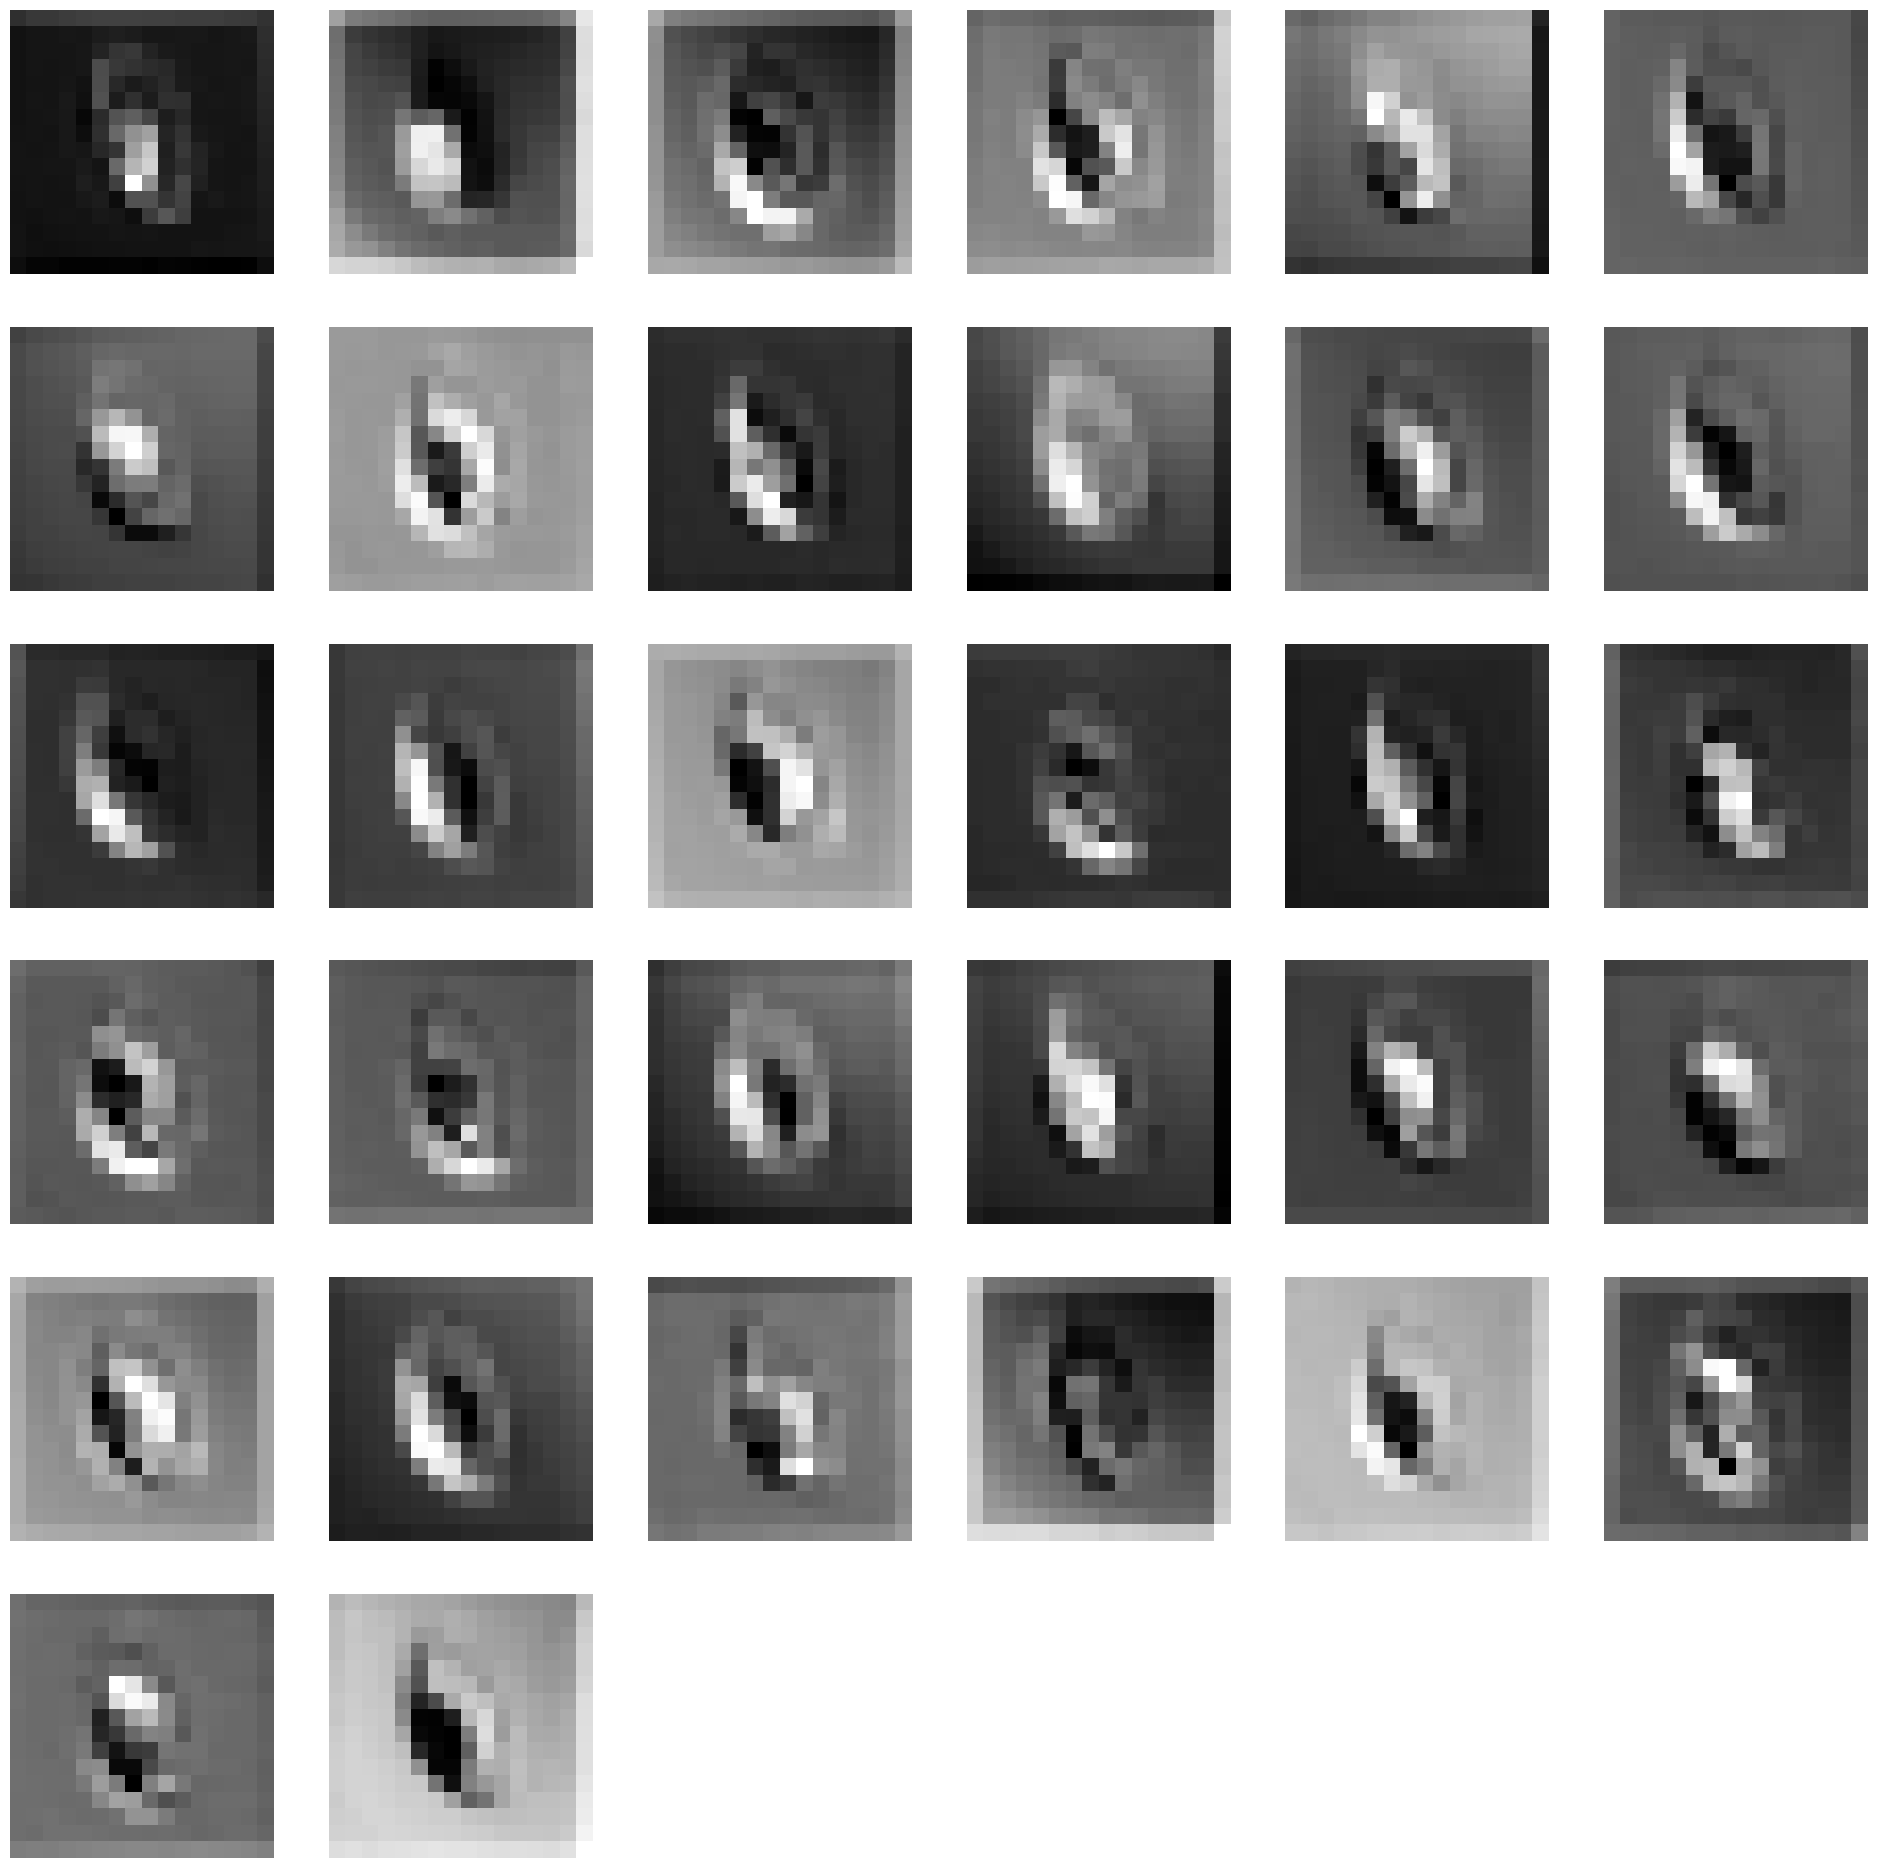

In [12]:
early_layers = cnn.layers[0:6]
part_cnn = tf.keras.models.Sequential(early_layers)
feature_maps3 = part_cnn.predict(X_test[0: 1])

size = feature_maps3.shape[3]
ncols = 6
nrows = (size - 1) // ncols + 1

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
for index in range(ncols * nrows):
    ax=axes[index // ncols][index % ncols]
    ax.axis('off')
    if index < size:
        ax.imshow(feature_maps3[0, :, :, index], cmap='gray')

### Fourth convolutional layer

1/1 [==============================] - 0s 134ms/step


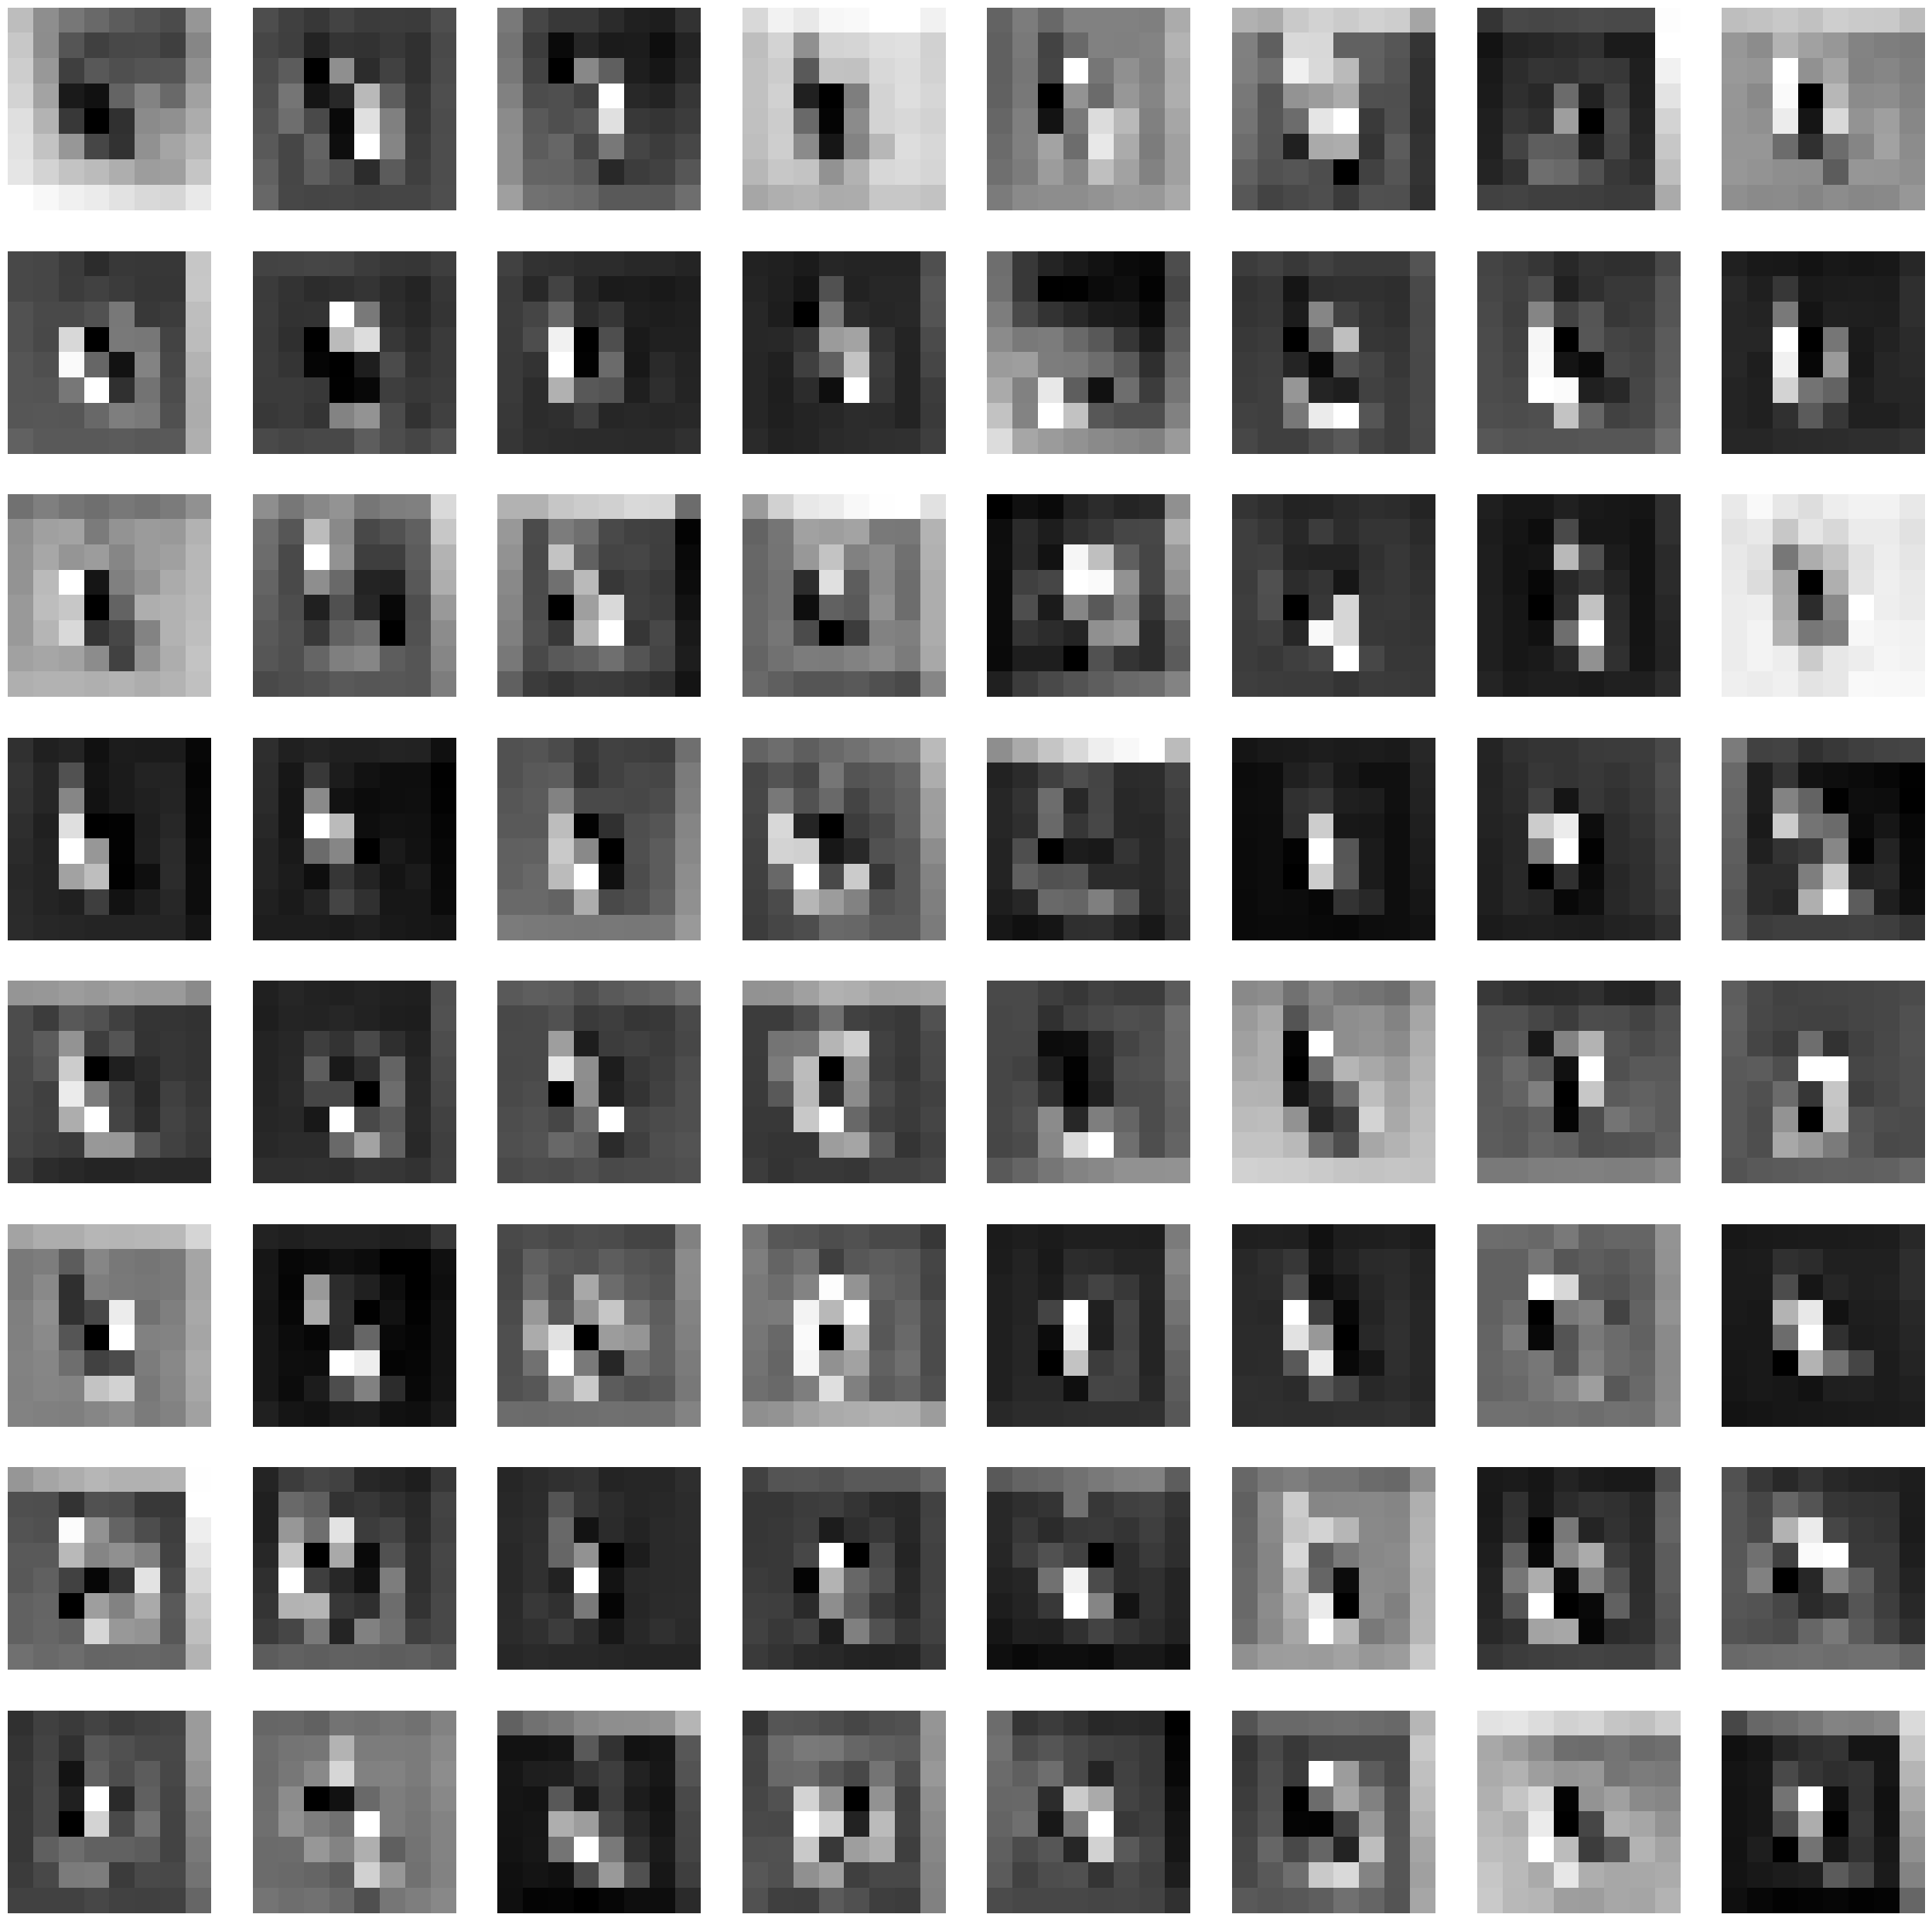

In [13]:
early_layers = cnn.layers[0:8]
part_cnn = tf.keras.models.Sequential(early_layers)
feature_maps4 = part_cnn.predict(X_test[0: 1])

size = feature_maps4.shape[3]
ncols = 8
nrows = (size - 1) // ncols + 1

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
for index in range(ncols * nrows):
    ax=axes[index // ncols][index % ncols]
    ax.axis('off')
    if index < size:
        ax.imshow(feature_maps4[0, :, :, index], cmap='gray')

### Highest convolutional layer

1/1 [==============================] - 0s 156ms/step


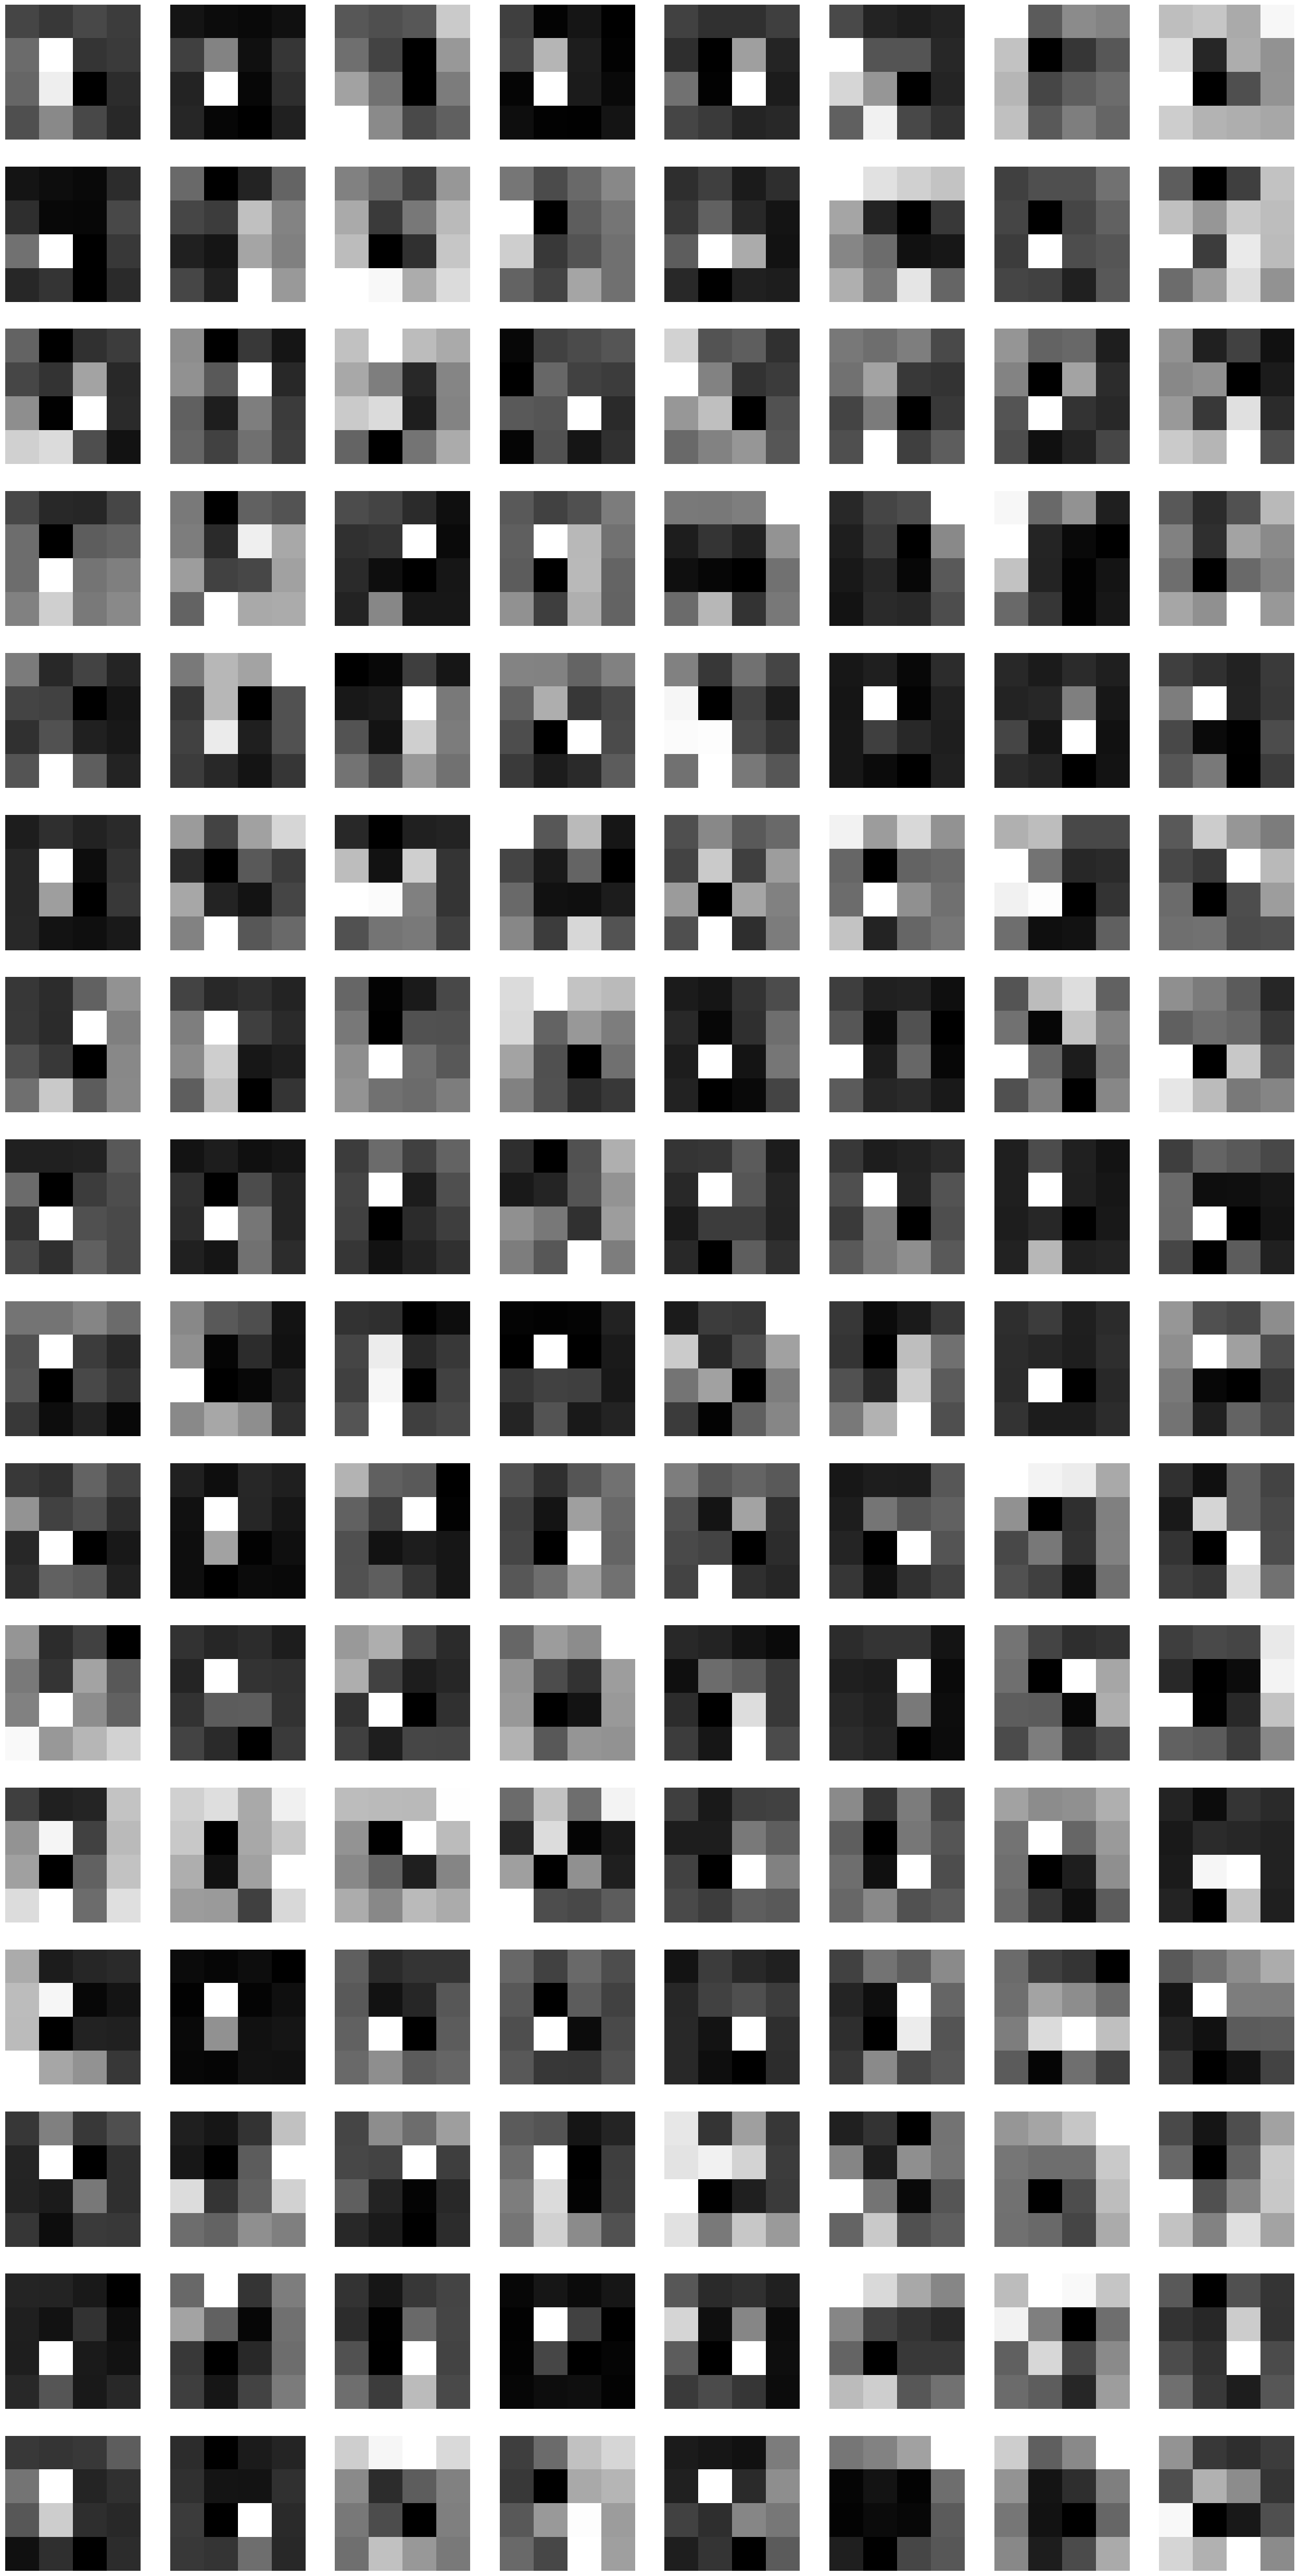

In [14]:
early_layers = cnn.layers[0:10]
part_cnn = tf.keras.models.Sequential(early_layers)
feature_maps5 = part_cnn.predict(X_test[0: 1])

size = feature_maps5.shape[3]
ncols = 8
nrows = (size - 1) // ncols + 1

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
for index in range(ncols * nrows):
    ax=axes[index // ncols][index % ncols]
    ax.axis('off')
    if index < size:
        ax.imshow(feature_maps5[0, :, :, index], cmap='gray')